In [1]:
import os
import re
import json
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from nltk.tokenize.punkt import PunktSentenceTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.tokenize import TreebankWordTokenizer
from nltk import pos_tag
from nltk.util import ngrams

In [3]:
from flashtext import KeywordProcessor
from interval import Interval
from collections import Counter
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier

In [4]:
from bert_serving.client import BertClient
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Bidirectional, Dropout
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention

Using TensorFlow backend.


In [5]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

In [6]:
# 相关数据文件路径
data_dir = "/home/denglizong/SSUMiner/corpus/"

In [7]:
# 疾病描述文本文件路径
corpus_path = '/home/denglizong/SSUMiner/corpus/WikiPediaR5'
# os.listdir( corpus_path )[0:3]

In [8]:
# 疾病名称列表
list_of_diseases = [ filename.replace('.txt',"") 
                    for filename in os.listdir( corpus_path ) if filename.endswith(".txt")]
#
list_of_diseases[0:3]                    

['Acinetobacter infections', 'Kawasaki disease', 'Paragonimiasis']

In [9]:
# 读入训练集和测试集的疾病名称索引
diseases_used_for_training = []
diseases_used_for_test = []

# 用于训练模型或调优规则的疾病文档
file_of_diseases_for_training = os.path.join( data_dir+"TrainTestSplit", "diseases_for_training.txt" )
with open( file_of_diseases_for_training, 'r', encoding='utf-8' ) as f:
    for line in f.readlines():
        if line.strip() != "":
            diseases_used_for_training.append( line.strip()  )

# 用于测试模型或测试规则的疾病文档
file_of_diseases_for_test = os.path.join( data_dir+"TrainTestSplit", "diseases_for_test.txt" )
with open( file_of_diseases_for_test, 'r', encoding='utf-8' ) as f:
    for line in f.readlines():
        if line.strip() != "":
            diseases_used_for_test.append( line.strip()  )

#
len( diseases_used_for_training ), len( diseases_used_for_test )            

(133, 60)

In [10]:
# 读取brat标注文件的函数
# 获取brat对应的标注文件中的实体span,名称及类型
# dict_of_brat_annotations.setdefault( ent_id, ('FindingSite', ent_name, pos_info) )    
# 将ent_id 和 pos_info的位置置换一下   
def read_brat_annotation_file( file_of_brat_annotation ):
    # 求解目标
    dict_of_brat_annotations = {}
    # 原文字符串
    text_string = ""
    with open(file_of_brat_annotation,'r',encoding='utf-8') as f:
        text_string = f.read()    
    # 注释文件内容
    ann_lines = []
    with open(file_of_brat_annotation,'r',encoding='utf-8') as f:
        ann_lines = f.readlines()
    # 解析注释文件中的内容
    for line in ann_lines:
        # 
        if line.startswith('T'): 
            # 表型实体
            if re.search('Phenotype',line,re.I):
                # T1	Phenotype 69 86	painful abscesses
                ent_id, ent_info, ent_name = line.strip().split('\t')
                # 位置信息 153 157;180 194
                pos_info = ent_info.replace('Phenotype ','')
                # 
                # dict_of_brat_annotations.setdefault( ent_id, ('Phenotype', ent_name, pos_info) )   
                dict_of_brat_annotations.setdefault( pos_info, ('Phenotype', ent_name, ent_id) )
            # 部位实体
            elif re.search('FindingSite',line,re.I):
                # T4	FindingSite 114 120	breast
                ent_id, ent_info, ent_name = line.strip().split('\t')
                # 位置信息 114 120
                pos_info = ent_info.replace('FindingSite ','')   
                #
                # dict_of_brat_annotations.setdefault( ent_id, ('FindingSite', ent_name, pos_info) )   
                dict_of_brat_annotations.setdefault( pos_info, ('FindingSite', ent_name, ent_id) )     
    #
    return dict_of_brat_annotations   
    

In [11]:
# 属性名称列表
# list_of_attributes = ['Assertion','Severity','Temporal','Sensation','Color','Magnitudes','Shape','Age','Gender',
#                      'Frequency','Relevance','Laterality','Quadrant','Distribution',
#                       'Stage','Phase','Type','SOI','Complication']
# 待预测的属性名称
list_of_attributes = ['Assertion','Severity','Temporal','Sensation','Color','Age','Gender',
                     'Frequency','Distribution','SOI']                   

In [12]:
# 
# 目标变量: annotated_phenotypes_info_of_diseases.setdefault(disease_name, info_of_annotated_phenotypes )
# list of info_of_annotated_phenotypes 以表型的id为key,记录表型的标注信息
# info_of_annotated_phenotypes.setdefault(pheno_id, tmpdict)
# 以表型为单位，包含以下信息记录到tmpdict
# tmpdict.setdefault("pheno_name",pheno_name)
# tmpdict.setdefault("pheno_pos",pheno_pos)
# tmpdict.setdefault("associated_sites", ';'.join(associated_finding_sites) )
# tmpdict.setdefault("associated_attributes", ';'.join(associated_attributes) )   
# 重置   
annotated_phenotypes_info_of_diseases = {}

for disease_name in list_of_diseases:
    # 疾病百科原文
    file_of_original_text  = os.path.join( corpus_path, disease_name + '.txt' )
    raw_text = open( file_of_original_text, 'r', encoding='utf-8').read() 
    # 莫非是 raw_text 没有替换'\n'的问题？(因为标注的时候有替换)
    # 还真的是这个问题
    raw_text = raw_text.replace('\n',' ')

    # 获取该疾病文本的人工标注
    # 原来是这里出错了，将 disease_name 设置为了 "Acinetobacter infections"
    file_of_brat_annotation  = os.path.join( corpus_path, disease_name + '.ann' )

    # 解析其中标注的表型信息
    info_of_annotated_phenotypes = {}  

    with open(file_of_brat_annotation,'r',encoding='utf-8') as f:

        # 载入标注文件的行
        lines = f.readlines()
        # 搜索标注的表型实体
        # 获取该文本中出现过的表型实体编号及其名称   ent_id, ent_name 
        dict_of_phenotypic_id_and_name = {}
        # 获取该文本中出现过的部位实体编号及其名称   ent_id, ent_name 
        dict_of_findingsite_id_and_name = {}
        # 记录表型实体与部位实体之间的关联          ent1_id, [ent2_id] 可能会关联多个部位
        dict_of_phenotypes_related_sites = {}   
        # 记录表型实体具有的属性信息                ent_id, [(att_name,att_value)] 可能会关联多个属性
        dict_of_phenotypes_related_attributes = {}         
        #
        for line in lines:
            # 表型实体，不包括部位实体
            if line.startswith('T'): 
                if re.search('Phenotype',line,re.I):
                    # T1	Phenotype 69 86	painful abscesses
                    ent_id, ent_info, ent_name = line.strip().split('\t')
                    # 位置信息 153 157;180 194
                    ent_pos = ent_info.replace('Phenotype ','')
                    # 
                    dict_of_phenotypic_id_and_name.setdefault( ent_id, (ent_name,ent_pos) )   
                elif re.search('FindingSite',line,re.I):
                    # T4	FindingSite 114 120	breast
                    ent_id, ent_info, ent_name = line.strip().split('\t')
                    dict_of_findingsite_id_and_name.setdefault( ent_id, ent_name )                
            # 找到关系 ，记录标注有部位的表型
            elif line.startswith('R'):
                if re.search('locate',line,re.I):
                    # R1	locate Arg1:T1 Arg2:T2	
                    rel_id, rel_info, tmp_str = line.split('\t')
                    # locate Arg1:T1 Arg2:T2
                    part_a, part_b, part_c = rel_info.split(' ')
                    # 
                    ent1_id = part_b.split(':')[1]
                    ent2_id = part_c.split(':')[1]
                    #
                    if ent1_id not in dict_of_phenotypes_related_sites:
                        dict_of_phenotypes_related_sites.setdefault( ent1_id, [ent2_id] )     
                    else:
                        dict_of_phenotypes_related_sites[ent1_id].append( ent2_id )
            # 属性行，关联到对应的表型实体
            elif line.startswith('A'):
                # A2	Assertion T6 Possible
                info_a, info_b = line.strip().split('\t')
                att_name, ent_id, att_value = info_b.split(' ') 
                # 除外'AgreeAnn','EqualRaw'属性
                if att_name not in ['AgreeAnn','EqualRaw']:
                    # 表型id, 属性名称，属性值
                    if ent_id not in dict_of_phenotypes_related_attributes:
                        dict_of_phenotypes_related_attributes.setdefault( ent_id, [(att_name,att_value)]  )
                    else:
                        dict_of_phenotypes_related_attributes[ent_id].append( (att_name,att_value) ) 
        #
        for pheno_id in dict_of_phenotypic_id_and_name:
            # 文档名称
            doc_name = disease_name
            # 表型名称  (ent_name,end_start,end_end)
            pheno_name = dict_of_phenotypic_id_and_name[pheno_id][0]
            # 表型位置
            pheno_pos = dict_of_phenotypic_id_and_name[pheno_id][1]
            # 关联部位名称 (分号隔开)
            associated_finding_sites = []
            if pheno_id in dict_of_phenotypes_related_sites:
                site_ids = dict_of_phenotypes_related_sites[pheno_id]
                for site_id in site_ids:
                    if site_id in dict_of_findingsite_id_and_name:
                        associated_finding_sites.append( dict_of_findingsite_id_and_name[site_id] )
            # 关联属性
            associated_attributes = []
            if pheno_id in dict_of_phenotypes_related_attributes:
                list_of_attrs = dict_of_phenotypes_related_attributes[pheno_id]
                for (_attr, _value) in list_of_attrs:
                    associated_attributes.append( _attr+":"+_value) 
            # 记录
            tmpdict = {}
            tmpdict.setdefault("pheno_name",pheno_name)
            tmpdict.setdefault("pheno_pos",pheno_pos)
            tmpdict.setdefault("associated_sites", ';'.join(associated_finding_sites) )
            tmpdict.setdefault("associated_attributes", ';'.join(associated_attributes) )                       
            # 
            info_of_annotated_phenotypes.setdefault(pheno_id, tmpdict)
            annotated_phenotypes_info_of_diseases.setdefault(disease_name, info_of_annotated_phenotypes )  

In [13]:
# 给定一份疾病文档，输出专家标注的表型信息
annotated_phenotypes_info_of_diseases['Actinomycosis']['T1']

{'pheno_name': 'painful abscesses',
 'pheno_pos': '69 86',
 'associated_sites': 'mouth;lungs;breast;gastrointestinal tract',
 'associated_attributes': 'Assertion:Present;Relevance:Distinctive_finding'}

In [12]:
# 进一步的，对于每一个标注的表型，记录表型所在的句子文本信息
# 将之增添到 annotated_phenotypes_info_of_diseases 变量中
for disease_name in list_of_diseases:
    # for the disease_name 

    # 疾病百科原文
    file_of_original_text  = os.path.join( corpus_path, disease_name + '.txt' )
    raw_text = open( file_of_original_text, 'r', encoding='utf-8').read() 
    # 莫非是 raw_text 没有替换'\n'的问题？(因为标注的时候有替换)
    # 还真的是这个问题 
    # 在S1A 使用MetaMap注释语料的过程中, 替换其中的'\n'为','
    raw_text = raw_text.replace('\n',',')

    # 读入文本文件，获取句子信息
    # text_sents = []
    for start, end in PunktSentenceTokenizer().span_tokenize(raw_text):
        # text_sents.append( (start,end, raw_text[start:end]) ) 
        sent_text = raw_text[start:end]
        
        # 遍历标注的表型
        for pheno_id in annotated_phenotypes_info_of_diseases[disease_name]:
            # 解析表型的起止位置
            pheno_info = annotated_phenotypes_info_of_diseases[disease_name][pheno_id]
            pheno_spos = int( pheno_info['pheno_pos'].split(' ')[0] )
            pheno_epos = int( pheno_info['pheno_pos'].split(' ')[-1] )

            # 进一步定位表型所在的句子,
            if pheno_spos >= start and pheno_epos<= end:  
                # 记录表型所在的句子
                if 'pheno_context' not in annotated_phenotypes_info_of_diseases[disease_name][pheno_id]:
                    annotated_phenotypes_info_of_diseases[disease_name][pheno_id].setdefault( 'pheno_context', sent_text )
                else:
                    annotated_phenotypes_info_of_diseases[disease_name][pheno_id]['pheno_context'] = sent_text
                # 记录表型在句子中的起始位置
                pheno_spos_in_sent = pheno_spos - start
                pheno_epos_in_sent = pheno_epos - start
                pos_info = (pheno_spos_in_sent, pheno_epos_in_sent)
                if pos_info not in annotated_phenotypes_info_of_diseases[disease_name][pheno_id]:
                    annotated_phenotypes_info_of_diseases[disease_name][pheno_id].setdefault( 'pheno_pos_in_sent', pos_info )

In [13]:
# 再看看现在记录到变量中的信息
annotated_phenotypes_info_of_diseases['Actinomycosis']['T1']

{'pheno_name': 'painful abscesses',
 'pheno_pos': '69 86',
 'associated_sites': 'mouth;lungs;breast;gastrointestinal tract',
 'associated_attributes': 'Assertion:Present;Relevance:Distinctive_finding',
 'pheno_context': 'Signs and symptoms,,The disease is characterised by the formation of painful abscesses in the mouth, lungs,[3][4] breast,[5] or gastrointestinal tract.',
 'pheno_pos_in_sent': (69, 86)}

In [17]:
# create bert encoding instance
bc = BertClient()

In [18]:
# 一个容忍错误的编码系统
def try_bert_encoding( list_with_one_item ):
    try:
        # 如果能正确编码，返回 
        encoding_of_item = bc.encode(list_with_one_item)[0]
        return encoding_of_item
    # except后面的ValueError是Python提供的标准异常名称，当传入函数的参数无效时，该异常被抛出。
    # Python提供了几十个标准异常名称，用于处理在不同情况下发生的异常。
    except ValueError:
        encoding_of_item = np.zeros(768)
        return encoding_of_item

In [21]:
# bc 测试
# print( bc.encode(['hi']) )

In [28]:
%%time
# 训练集表征
# 根据训练集中的疾病名称，读入用于机器学习的输入信息
# 目标 : x_train, y_train
# x_train [ [上文,实体,下文], [上文,实体,下文], ]
# y_train [ [Present]      , [Possible]     , ]

# list of context/pheno/context vectors (3*768 ndarray) encoding with bert
training_list_of_pheno_vectors = []
# associated attributes of phenotype (all labels)
training_list_of_pheno_labels  = []


for disease_name in list( annotated_phenotypes_info_of_diseases.keys() ):
    # 仅看训练集中的疾病
    if disease_name not in diseases_used_for_training:
        continue

    # 该疾病文档中标注的表型及其关联属性
    info_of_annotated_phenotypes = annotated_phenotypes_info_of_diseases[disease_name]

    # 对于该疾病文档中标注的每一个表型
    for pheno_id in info_of_annotated_phenotypes:
        # 获取该变量中存储的表型相关信息
        pheno_info = info_of_annotated_phenotypes[pheno_id]

        # 如果该表型没有上下文，跳过
        if 'pheno_context' not in pheno_info:
            continue

        # 表型的名称
        pheno_name = pheno_info['pheno_name']
        # 表型所在的句子 (有的表型没有"pheno_context") )
        pheno_text = pheno_info['pheno_context']
        # 表型在句子中的位置 (注意pheno_epos-1)才是表型最后一个字符串的位置
        pheno_spos, pheno_epos = pheno_info['pheno_pos_in_sent']     
        pheno_epos = pheno_epos-1
        # 表型的关联属性
        pheno_labels = pheno_info['associated_attributes'] 
        # 记录表型的关联属性
        training_list_of_pheno_labels.append( pheno_labels )   

        # 表型的上下文
        left_context = pheno_text[:pheno_spos]
        right_context = pheno_text[pheno_epos+1:]


        # generate representation of phenotype entity and its context
        vec_0 = try_bert_encoding( [pheno_name] )
        vec_1 = try_bert_encoding( [left_context] )
        vec_2 = try_bert_encoding( [right_context] )  

        # 用于表征该表型及其上下文的表征向量 3*758 的二维向量 
        # context/phenotype/context
        pheno_vector = np.array( [vec_1, vec_0, vec_2] )
        # n sample * 3 * 758
        training_list_of_pheno_vectors.append(pheno_vector)        

/home/denglizong/SSUMiner/lib/python3.6/site-packages/bert_serving/client/__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=50" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)
CPU times: user 2.94 s, sys: 933 ms, total: 3.87 s
Wall time: 12min


In [508]:
%%time
# 测试集表征
# 根据训练集中的疾病名称，读入用于机器学习的输入信息
# 目标 : x_train, y_train
# x_train [ [上文,实体,下文], [上文,实体,下文], ]
# y_train [ [Present]      , [Possible]     , ]

# list of context/pheno/context vectors (3*768 ndarray) encoding with bert
testing_list_of_pheno_vectors = []

# 带上 disease_name , phenoid 的标记，便于追踪
testing_list_of_pheno_ids = []

# associated attributes of phenotype (all labels)
testing_list_of_pheno_labels  = []


for disease_name in list( annotated_phenotypes_info_of_diseases.keys() ):
    # 仅看训练集中的疾病
    if disease_name not in diseases_used_for_test:
        continue

    # 该疾病文档中标注的表型及其关联属性
    info_of_annotated_phenotypes = annotated_phenotypes_info_of_diseases[disease_name]

    # 对于该疾病文档中标注的每一个表型
    for pheno_id in info_of_annotated_phenotypes:
        # 获取该变量中存储的表型相关信息
        pheno_info = info_of_annotated_phenotypes[pheno_id]

        # 如果该表型没有上下文，跳过
        if 'pheno_context' not in pheno_info:
            continue

        # 表型的名称
        pheno_name = pheno_info['pheno_name']
        # 表型所在的句子 (有的表型没有"pheno_context") )
        pheno_text = pheno_info['pheno_context']
        # 表型在句子中的位置 (注意pheno_epos-1)才是表型最后一个字符串的位置
        pheno_spos, pheno_epos = pheno_info['pheno_pos_in_sent']     
        pheno_epos = pheno_epos-1
        # 表型的关联属性
        pheno_labels = pheno_info['associated_attributes'] 
        # 记录表型的关联属性
        testing_list_of_pheno_labels.append( pheno_labels )
        # 同步该表型的文档坐标
        testing_list_of_pheno_ids.append( (disease_name, pheno_id)  )

        # 表型的上下文
        left_context = pheno_text[:pheno_spos]
        right_context = pheno_text[pheno_epos+1:]


        # generate representation of phenotype entity and its context
        vec_0 = try_bert_encoding( [pheno_name] )
        vec_1 = try_bert_encoding( [left_context] )
        vec_2 = try_bert_encoding( [right_context] )  

        # 用于表征该表型及其上下文的表征向量 3*758 的二维向量 
        # context/phenotype/context
        pheno_vector = np.array( [vec_1, vec_0, vec_2] )
        # n sample * 3 * 758
        testing_list_of_pheno_vectors.append(pheno_vector)        

/home/denglizong/SSUMiner/lib/python3.6/site-packages/bert_serving/client/__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=50" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)
CPU times: user 1.29 s, sys: 541 ms, total: 1.83 s
Wall time: 4min 33s


In [512]:
testing_list_of_pheno_vectors[0]

array([[-0.19783789,  0.4683154 , -0.1640877 , ..., -0.5582233 ,
        -0.12880503,  0.41255882],
       [-0.11694559, -0.24064814, -0.5739989 , ..., -0.31650406,
        -0.4624267 , -0.16003573],
       [-0.32084447,  0.41119006,  0.25170118, ..., -0.6653215 ,
        -0.58424926, -0.13244563]], dtype=float32)

In [511]:
testing_list_of_pheno_ids[0:3]

[('Acinetobacter infections', 'T1'),
 ('Acinetobacter infections', 'T2'),
 ('Acinetobacter infections', 'T3')]

In [30]:
# 建立单属性预测 y_label 所需要的函数
# list_of_pheno_labels --> list_of_pheno_labels_for_target_attribute
# 'Assertion:Possible;Frequency:Frequent;Gender:Female' --> 'Assertion:Possible'
# 对于Assertion必选属性，由于每一个属性都有，故每一个表型都有
# 但对于其它非必选属性 ，如果该表型没有这一属性，应设置为 '属性:NONE', 这也是一种选择
def get_list_of_labels_for_target_attribute( list_of_pheno_labels, target_attribute_name ):
    #
    list_of_pheno_labels_wanted = []
    # 
    for pheno_labels_str in list_of_pheno_labels:
        # 'Assertion:Possible;Frequency:Frequent;Gender:Female'
        found_attr_value_wanted = False
        for pheno_label in pheno_labels_str.split(';'):
            # 'Assertion' in 'Assertion:Possible'
            # 找到该属性对应的属性:取值记录 
            if target_attribute_name in pheno_label:
                list_of_pheno_labels_wanted.append( pheno_label )
                found_attr_value_wanted = True
                break
        # 如果没有找到该属性对应的取值记录
        # 填充属性:NONE，这也是一种选择，说明上下文中没有这个属性的描述
        if found_attr_value_wanted == False and target_attribute_name not in ['Assertion']:
            list_of_pheno_labels_wanted.append( target_attribute_name + ':' +'None' )
    #
    return list_of_pheno_labels_wanted

In [35]:
# 观察 某一具体属性(wanted_attr_name)在疾病文档(disease_names)中取值分布的函数
# {value 1: count 1, value 2: count 2}
# occurences_of_attribute_values = {}
def stat_occurences_of_attribute_values( wanted_attr_name, disease_names ):
    # 
    dict_of_attribute_value_distribution = {}

    #
    for disease_name in disease_names:
        # 这一疾病对应的文本文件和标注文件
        # textfilepath = os.path.join( filepath, disease_names+'.txt')
        annfilepath  = os.path.join( corpus_path, disease_name+'.ann')
        
        # 读入标注文件
        with open(annfilepath,'r',encoding='utf-8') as f:
            # 载入标注文件的行
            lines = f.readlines()     
            # 找到属性行
            for line in lines:
                # 解析属性行，
                if line.startswith('A'):
                    # 解析属性行中的属性名称
                    # A2	Assertion T6 Possible
                    info_a, info_b = line.strip().split('\t')
                    att_name, ent_id, att_value = info_b.split(' ')                     
                    # 如果是需要统计的属性
                    if att_name == wanted_attr_name:
                        # 统计属性值
                        if att_value not in dict_of_attribute_value_distribution:
                            dict_of_attribute_value_distribution.setdefault(att_value, 1)
                        else:
                            dict_of_attribute_value_distribution[att_value] +=1
    #
    return dict_of_attribute_value_distribution                                

In [31]:
# 开始属性预测模型的构建、调优之旅

In [604]:
print(list_of_attributes)

['Assertion', 'Severity', 'Temporal', 'Sensation', 'Color', 'Age', 'Gender', 'Frequency', 'Distribution', 'SOI']


In [125]:
dict_of_trained_classifiers = {}

In [797]:
# 1. Constructing 'Assertion' Attribute slot filling model
target_attribute = 'Temporal'

In [798]:
# y_labels of 'Assertion'
# training_list_of_pheno_labels for target_attribute
filted_training_list_of_pheno_labels = get_list_of_labels_for_target_attribute( training_list_of_pheno_labels, target_attribute ) 
filted_training_list_of_pheno_labels[0:3] 

['Temporal:Prolonged', 'Temporal:None', 'Temporal:None']

In [799]:
# 对目标属性的取值进行数字编码
codes_of_attribute_values = {}

# default的属性取值设置为0
if target_attribute == 'Assertion':
    codes_of_attribute_values.setdefault( "Present", 0 )
else:
    codes_of_attribute_values.setdefault( "None", 0 )  


# 观察目标属性在语料集中的出现情况
# 观察目标属性在训练集中的出现情况
present_of_attribute_values = stat_occurences_of_attribute_values(target_attribute, diseases_used_for_training)
# 该属性在训练集中出现的类别数 len( present_of_attribute_values )

# 对出现过的目标属性取值进行数字编码
for attribute_value in present_of_attribute_values:
    if attribute_value != 'Present':
        # 赋予编号
        count_of_attribute_value = present_of_attribute_values[ attribute_value ] 
        #
        code_of_attribute_value = len( codes_of_attribute_values )
        codes_of_attribute_values.setdefault( attribute_value , code_of_attribute_value )  

# 符合样本数条件的属性类
codes_of_attribute_values

{'None': 0,
 'Chronic': 1,
 'Nocturnal': 2,
 'Acute': 3,
 'Subacute': 4,
 'Recurrent': 5,
 'Transient': 6,
 'Prolonged': 7}

In [800]:
# 通过 filted_training_list_of_pheno_labels 观察 每一种属性取值的分布
# 可以看到 'Assertion:Hypothetical' (4) 和 'Assertion:Absent' (16)的样本数都很少
# 所有，可以考虑只保留 'Assertion:Present'/'Assertion:Possible'/'Assertion:Conditional'三种类型
# 构建一个3分类器
Counter( filted_training_list_of_pheno_labels )

Counter({'Temporal:Prolonged': 11,
         'Temporal:None': 2782,
         'Temporal:Subacute': 2,
         'Temporal:Transient': 6,
         'Temporal:Acute': 47,
         'Temporal:Chronic': 47,
         'Temporal:Recurrent': 6,
         'Temporal:Nocturnal': 6})

In [801]:
# 删除数量过少的类 (SMOTE k-means方法的数量限定) (样本数量 < 分类数量)
excluded_attr_names = []
# occurrence_threshold = len( codes_of_attribute_values )
occurrence_threshold = 15

for attr_name, count in Counter( filted_training_list_of_pheno_labels ).items():
    if count < occurrence_threshold:
        excluded_attr_names.append( attr_name )

excluded_attr_names

['Temporal:Prolonged',
 'Temporal:Subacute',
 'Temporal:Transient',
 'Temporal:Recurrent',
 'Temporal:Nocturnal']

In [802]:
# 对训练集中的 list_of_pheno_vectors 和 list_of_pheno_labels 进行修正
# 去除不需要的pheno_labels
excluded_pheno_idx = []
for idx, item in enumerate( filted_training_list_of_pheno_labels ):
    if item in excluded_attr_names:
        excluded_pheno_idx.append( idx )

# 16 + 4
len(excluded_pheno_idx)

31

In [803]:
# 对训练集中的 list_of_pheno_vectors 和 list_of_pheno_labels 进行修正
# 去除不需要的pheno_labels
new_training_list_of_pheno_vectors = []
new_training_list_of_pheno_labels  = []


for idx, item in enumerate( filted_training_list_of_pheno_labels ):
    if idx not in excluded_pheno_idx:
        new_training_list_of_pheno_vectors.append( training_list_of_pheno_vectors[idx]  )
        new_training_list_of_pheno_labels.append( filted_training_list_of_pheno_labels[idx] )        

In [804]:
# 将 training labels 和 testing labels 从文字形态转为数字形态
# 类的删除对 training_list_of_pheno_labels_by_int有影响吗？
# 7个零，training_labels 中只有3个位置有 1 的存在，纳入训练
# 但 test_labels中所有原始标注均保留 
# training y_labels as int
training_list_of_pheno_labels_by_int = []

for label in new_training_list_of_pheno_labels:
    attribute_value = label.split(':')[1]
    value_code = codes_of_attribute_values[attribute_value]
    training_list_of_pheno_labels_by_int.append( value_code )

training_list_of_pheno_labels_by_int[0:3]

[0, 0, 0]

In [805]:
# 将y_labels转为one-hot (0/1)表征
# 从数字形态的类别变量转为one hot形态的类别变量
# 第一类 --> 1 0 0 0 0; 第二类 --> 0 1 0 0 0
# num_of_classes 属性的取值列表数目
num_of_classes = len(codes_of_attribute_values)
#
training_list_of_pheno_labels_in_one_hot = to_categorical( training_list_of_pheno_labels_by_int, num_of_classes )
#
training_list_of_pheno_labels_in_one_hot[0:3]

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [806]:
# 生成x_train, y_train / x_test, y_test [向量形式]
# 注意，这是x_train和y_train的原始形式，可直接按之前的步骤进行训练
# 但这是imbalance dataset, 所有可能需要imbalance learning技术
x_train = np.array( new_training_list_of_pheno_vectors )
y_train = training_list_of_pheno_labels_in_one_hot
#
len(x_train), len(y_train)

(2876, 2876)

In [807]:
# 保留一部分(20%)训练集数据作为验证集
# 验证集要保留真实情况，不能用SMOTE
# validation set
# x
split_ratio = 0.8
split_index = int( len(x_train)*split_ratio )
#
partial_x_train = x_train[:split_index]
x_val = x_train[split_index:]
# y
partial_y_train = y_train[:split_index]
y_val = y_train[split_index:]
# y_labels for partial_x_train
partial_y_labels = new_training_list_of_pheno_labels[:split_index]
#
split_index, len( partial_y_labels ), len(partial_y_train)

(2300, 2300, 2300)

In [808]:
# 使用SMOTE技术平衡数据集
smo = SMOTE(random_state=168, k_neighbors=3)

In [809]:
# 对 partial_x_train, partial_y_train 进行重采样
reshaped_x_train = partial_x_train.reshape( partial_x_train.shape[0],-1 )
reshaped_x_train.shape

(2300, 2304)

In [810]:
%%time
# x_train 对应的标签是 new_training_list_of_pheno_labels
resampled_x_train, resampled_y_labels = smo.fit_sample(reshaped_x_train, partial_y_labels)

CPU times: user 244 ms, sys: 379 ms, total: 623 ms
Wall time: 620 ms


In [811]:
Counter(resampled_y_labels)

Counter({'Temporal:None': 2230,
         'Temporal:Acute': 2230,
         'Temporal:Chronic': 2230})

In [812]:
# reshape回来 
new_x_train = resampled_x_train.reshape( ( resampled_x_train.shape[0], x_train.shape[1], x_train.shape[2] ) )
new_x_train.shape

(6690, 3, 768)

In [813]:
resampled_y_labels[0:3]

['Temporal:None', 'Temporal:None', 'Temporal:None']

In [814]:
# 再生成配套的new_y_train
# 还是首先将 resampled_y_labels 转成 resampled_y_labels_as_int
resampled_y_labels_as_int = []
for label in resampled_y_labels:
    attribute_value = label.split(':')[1]
    value_code = codes_of_attribute_values[attribute_value]
    resampled_y_labels_as_int.append( value_code )

resampled_y_labels_as_int[0:3]


[0, 0, 0]

In [815]:
# 再将 resampled_y_labels_as_int 转成 resampled_y_labels_as_onehot
# 最后记录到 new_y_train 中
resampled_y_labels_as_onehot = to_categorical( resampled_y_labels_as_int, num_of_classes )
new_y_train = resampled_y_labels_as_onehot

In [816]:
# 最后还是需要对所有数据进行训练，所有还是需要对所有数据进行一次重采样
# 要不就提前把x_train, x_val, x_test分开，这样可能会方便一些

In [817]:
# 对 x_train, y_train 进行重采样
reshaped_x_train = x_train.reshape( x_train.shape[0],-1 )
reshaped_x_train.shape

(2876, 2304)

In [818]:
%%time
# x_train 对应的标签是 new_training_list_of_pheno_labels
resampled_x_train, resampled_y_labels = smo.fit_sample(reshaped_x_train, new_training_list_of_pheno_labels )

CPU times: user 295 ms, sys: 454 ms, total: 749 ms
Wall time: 745 ms


In [819]:
# reshape回来 
all_x_train = resampled_x_train.reshape( ( resampled_x_train.shape[0], x_train.shape[1], x_train.shape[2] ) )
all_x_train.shape

(8346, 3, 768)

In [820]:
# 再生成配套的new_y_train
# 还是首先将 resampled_y_labels 转成 resampled_y_labels_as_int
resampled_y_labels_as_int = []
for label in resampled_y_labels:
    attribute_value = label.split(':')[1]
    value_code = codes_of_attribute_values[attribute_value]
    resampled_y_labels_as_int.append( value_code )

resampled_y_labels_as_int[0:3]

[0, 0, 0]

In [821]:
# 再将 resampled_y_labels_as_int 转成 resampled_y_labels_as_onehot
# 最后记录到 new_y_train 中
resampled_y_labels_as_onehot = to_categorical( resampled_y_labels_as_int, num_of_classes )
all_y_train = resampled_y_labels_as_onehot
len( all_y_train )

8346

In [822]:
# 构建神经网络模型进行训练

In [823]:
# input_shape 设置
input_shape = x_train[0].shape
input_shape

(3, 768)

In [824]:
# 搭建网络
# create model
model = Sequential()
# BiLSTM + Attention
# 超参数 LSTM/GRU  神经元数目 32/64/128
model.add( Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape) )
model.add( SeqWeightedAttention() )
model.add( Dropout(0.2) )
# NN Output
model.add( Dense(num_of_classes, activation='softmax') )
#
# compile model
# 无论你的问题是什么， rmsprop 优化器通常都是足够好的选择
# 超参数：除学习率可调整外，建议保持优化器的其他默认参数不变. default lr=0.001
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_53 (Bidirectio (None, 3, 128)            426496    
_________________________________________________________________
seq_weighted_attention_49 (S (None, 128)               129       
_________________________________________________________________
dropout_44 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 8)                 1032      
Total params: 427,657
Trainable params: 427,657
Non-trainable params: 0
_________________________________________________________________


In [825]:
# training model 
# 超参数: epochs, batch_size (32常用、64、128、256都比较合适)
# 要选择合适的Epochs，就可以用early stopping的方法
history = model.fit( new_x_train, new_y_train, epochs=10, batch_size=64, validation_data=(x_val, y_val) )

Train on 6690 samples, validate on 576 samples
Epoch 1/10
6690/6690 [==============================] - 9s 1ms/step - loss: 0.5061 - acc: 0.7970 - val_loss: 0.2898 - val_acc: 0.8889
Epoch 2/10
6690/6690 [==============================] - 1s 149us/step - loss: 0.1236 - acc: 0.9608 - val_loss: 0.2654 - val_acc: 0.9080
Epoch 3/10
6690/6690 [==============================] - 1s 136us/step - loss: 0.0659 - acc: 0.9795 - val_loss: 0.1894 - val_acc: 0.9497
Epoch 4/10
6690/6690 [==============================] - 1s 136us/step - loss: 0.0367 - acc: 0.9900 - val_loss: 0.2214 - val_acc: 0.9549
Epoch 5/10
6690/6690 [==============================] - 1s 136us/step - loss: 0.0190 - acc: 0.9954 - val_loss: 0.2435 - val_acc: 0.9566
Epoch 6/10
6690/6690 [==============================] - 1s 132us/step - loss: 0.0169 - acc: 0.9945 - val_loss: 0.3049 - val_acc: 0.9566
Epoch 7/10
6690/6690 [==============================] - 1s 139us/step - loss: 0.0144 - acc: 0.9960 - val_loss: 0.2867 - val_acc: 0.9583
Epo

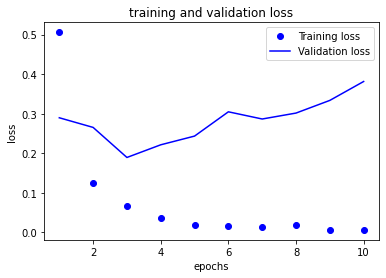

In [826]:
# 绘制训练损失和验证损失 (当然也可人眼看)
history_dict = history.history
loss_values = history_dict['loss']
epochs = range(1, len(loss_values)+1)
val_loss_values = history_dict['val_loss']
# 蓝色圆点
# plt.clf()
plt.plot( epochs, loss_values, 'bo', label='Training loss' )
# 蓝色实线
plt.plot( epochs, val_loss_values, 'b', label='Validation loss' )
# 在第11轮的时候validation上的loss达到最小值了
plt.title('training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
# 这张图看起来与图3-7更为接近

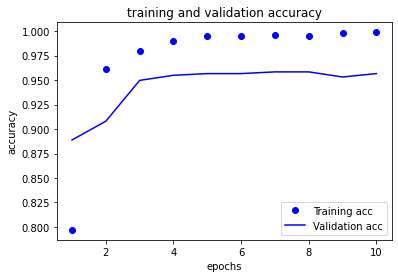

In [827]:
# 绘制训练精度和验证精度
# 清空图像
plt.clf()
acc = history_dict['acc']
val_acc = history_dict['val_acc']

# 蓝色圆点
plt.plot( epochs, acc, 'bo', label='Training acc' )
# 蓝色实线
plt.plot( epochs, val_acc, 'b', label='Validation acc' )
# 在第六轮的时候validation上的loss达到最小值了
plt.title('training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()


In [451]:
# 重新训练一个模型

In [828]:
# 搭建网络
# create model
model = Sequential()
# BiLSTM + Attention
# 超参数 LSTM/GRU  神经元数目 32/64/128
model.add( Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape) )
model.add( SeqWeightedAttention() )
model.add( Dropout(0.2) )
# NN Output
model.add( Dense(num_of_classes, activation='softmax') )
#
# compile model
# 无论你的问题是什么， rmsprop 优化器通常都是足够好的选择
# 超参数：除学习率可调整外，建议保持优化器的其他默认参数不变. default lr=0.001
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_54 (Bidirectio (None, 3, 128)            426496    
_________________________________________________________________
seq_weighted_attention_50 (S (None, 128)               129       
_________________________________________________________________
dropout_45 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 8)                 1032      
Total params: 427,657
Trainable params: 427,657
Non-trainable params: 0
_________________________________________________________________


In [829]:
# 使用所有的数据进行训练
# early stopping at epochs=2
model.fit( all_x_train, all_y_train, epochs=3, batch_size=64 )

Epoch 1/3
8346/8346 [==============================] - 6s 711us/step - loss: 0.4639 - acc: 0.8186
Epoch 2/3
8346/8346 [==============================] - 1s 128us/step - loss: 0.1244 - acc: 0.9605
Epoch 3/3
8346/8346 [==============================] - 1s 126us/step - loss: 0.0565 - acc: 0.9841


In [830]:
# 保存模型
if target_attribute not in dict_of_trained_classifiers:
    dict_of_trained_classifiers.setdefault( target_attribute, model )
else:
    dict_of_trained_classifiers[target_attribute] = model

In [831]:
dict_of_trained_classifiers

{'Assertion': <keras.engine.sequential.Sequential at 0x7fe07a1394a8>,
 'Severity': <keras.engine.sequential.Sequential at 0x7fdf1c7e5e48>,
 'Temporal': <keras.engine.sequential.Sequential at 0x7fe075fcafd0>,
 'Sensation': <keras.engine.sequential.Sequential at 0x7fe08548d668>,
 'Color': <keras.engine.sequential.Sequential at 0x7fe084d3b518>,
 'Age': <keras.engine.sequential.Sequential at 0x7fe084365160>,
 'Gender': <keras.engine.sequential.Sequential at 0x7fe078da1240>,
 'Frequency': <keras.engine.sequential.Sequential at 0x7fe079c7d470>,
 'Distribution': <keras.engine.sequential.Sequential at 0x7fe06ae1f6a0>,
 'SOI': <keras.engine.sequential.Sequential at 0x7fe076ade860>}

In [502]:
# dict_of_trained_classifiers[target_attribute].predict( all_x_train )

In [503]:
# 基于上述模型对测试集进行预测，并将 annotation 变量中增加预测的属性值

In [504]:
# list of context/pheno/context vectors (3*768 ndarray) encoding with bert
# testing_list_of_pheno_vectors = []
# 带上 disease_name , phenoid 的标记，便于追踪
# testing_list_of_pheno_ids = []

In [832]:
# 
results = dict_of_trained_classifiers['Severity'].predict( np.array(testing_list_of_pheno_vectors) )

In [833]:
Counter( list( np.argmax(results, axis=1)  )  ) 

Counter({0: 1064, 1: 32, 2: 8})

In [834]:
# testing_list_of_pheno_vectors[0]

In [835]:
%%time
# 测试集上表型各个属性的预测值
dict_of_pred_attributes = {}

for attribute_name in dict_of_trained_classifiers:

    # 对目标属性的取值进行数字编码
    codes_of_attribute_values = {}
    #
    # default的属性取值设置为0
    if attribute_name == 'Assertion':
        codes_of_attribute_values.setdefault( 0, "Present")
    else:
        codes_of_attribute_values.setdefault( 0, "None" )  
    #
    # 观察目标属性在语料集中的出现情况
    # 观察目标属性在训练集中的出现情况
    present_of_attribute_values = stat_occurences_of_attribute_values(attribute_name, diseases_used_for_training)
    # 该属性在训练集中出现的类别数 len( present_of_attribute_values )
    #
    # 对出现过的目标属性取值进行数字编码
    for attribute_value in present_of_attribute_values:
        if attribute_value != 'Present':
            # 赋予编号
            count_of_attribute_value = present_of_attribute_values[ attribute_value ] 
            #
            code_of_attribute_value = len( codes_of_attribute_values )
            codes_of_attribute_values.setdefault( code_of_attribute_value, attribute_value )


    # 该属性的预测模型
    attr_pred_model = dict_of_trained_classifiers[attribute_name]
    # 预测测试集
    test_preds = attr_pred_model.predict( np.array(testing_list_of_pheno_vectors) ) 
    # 对预测结果进行解码
    test_labels = []
    # codes_of_attribute_values {'None': 0, 'Severe_problem': 1, 'Mild_problem': 2}
    for idx in list( np.argmax(test_preds, axis=1)  ):
        test_labels.append( codes_of_attribute_values[idx] )  

    #
    print(attribute_name, codes_of_attribute_values)  
    print( Counter(test_labels) )      

    # 记录
    if attribute_name not in dict_of_pred_attributes: 
        dict_of_pred_attributes.setdefault( attribute_name, test_labels )
    else:
        dict_of_pred_attributes[attribute_name] = test_labels 

Assertion {0: 'Present', 1: 'Possible', 2: 'Conditional', 3: 'Absent', 4: 'Hypothetical'}
Counter({'Present': 652, 'Possible': 450, 'Conditional': 2})
Severity {0: 'None', 1: 'Severe', 2: 'Mild', 3: 'Moderate_to_Severe', 4: 'Life_threatening_severity', 5: 'Mild_to_Moderate'}
Counter({'None': 1064, 'Severe': 32, 'Mild': 8})
Temporal {0: 'None', 1: 'Chronic', 2: 'Nocturnal', 3: 'Acute', 4: 'Subacute', 5: 'Recurrent', 6: 'Transient', 7: 'Prolonged'}
Counter({'None': 1077, 'Acute': 15, 'Chronic': 12})
Sensation {0: 'None', 1: 'Tender', 2: 'Burning', 3: 'Painless', 4: 'Cramping', 5: 'Stabbing', 6: 'Pricking', 7: 'Tinkling', 8: 'Colicky', 9: 'Hot'}
Counter({'None': 1087, 'Tender': 5, 'Burning': 4, 'Painless': 4, 'Cramping': 4})
Color {0: 'None', 1: 'Gray', 2: 'Red', 3: 'Black', 4: 'White', 5: 'Yellow_green', 6: 'Pink', 7: 'Yellow', 8: 'Green', 9: 'Blue'}
Counter({'None': 1067, 'Red': 30, 'Black': 5, 'Gray': 2})
Age {0: 'None', 1: 'Childhood', 2: 'Pregnancy', 3: 'Adult', 4: 'Infancy', 5: 'Neo

In [836]:
# dict_of_pred_attributes.keys()

In [837]:
dict_of_pred_attributes['Severity'][0:3]

['None', 'None', 'None']

In [838]:
# 将预测结果更新到 annotated_phenotypes_info_of_diseases
for disease_name in list( annotated_phenotypes_info_of_diseases.keys() ):
    # 仅看训练集中的疾病
    if disease_name not in diseases_used_for_test:
        continue

    # 
    # 该疾病文档中标注的表型及其关联属性
    info_of_annotated_phenotypes = annotated_phenotypes_info_of_diseases[disease_name]

    # 对于该疾病文档中标注的每一个表型
    for pheno_id in info_of_annotated_phenotypes:
        # 获取该变量中存储的表型相关信息
        pheno_info = info_of_annotated_phenotypes[pheno_id]


        # 设置该表型属性槽的默认值 (同时记录判断依据)
        default_values_of_attributes = {}

        # 这里其实没有触发信号，但还是这样保留着吧; 只考虑模型能够预测的属性列表
        for attribute_name in list_of_attributes:
            if attribute_name == 'Assertion':
                default_values_of_attributes.setdefault( attribute_name, ['Present',''] )
            else:
                default_values_of_attributes.setdefault( attribute_name, ['None',''] )   

        #  
        # 之前的一个问题 (这种表型的属性槽设置为全部默认即可) 数量不多，9个
        if 'pheno_context' not in pheno_info or (disease_name, pheno_id) not in testing_list_of_pheno_ids:
            if 'pred_attribute_values' not in annotated_phenotypes_info_of_diseases[disease_name][pheno_id]:
                annotated_phenotypes_info_of_diseases[disease_name][pheno_id].setdefault( 'pred_attribute_values', 
                                                                                        default_values_of_attributes )
            else:
                annotated_phenotypes_info_of_diseases[disease_name][pheno_id]['pred_attribute_values'] =        default_values_of_attributes   
            #            
            # 跳过后续操作
            continue      

        
        # 获取模型填充的各属性取值
        # 根据 disease_name, pheno_id 搜索其在 testing_list_of_pheno_ids 中的索引
        if (disease_name, pheno_id) in testing_list_of_pheno_ids:
            idx_in_preds = testing_list_of_pheno_ids.index( (disease_name, pheno_id) )
            # 据此获取 dict_of_pred_attributes.setdefault( attribute_name, test_labels ) 
            for attribute_name in dict_of_pred_attributes:
                # 更新默认值 dict_of_pred_attributes[attribute_name][ idx_in_preds ]
                default_values_of_attributes[ attribute_name ][0] = dict_of_pred_attributes[attribute_name][ idx_in_preds ]
        
        # 记录更改后的 default_values_of_attributes 到该表型的信息中
        if 'pred_attribute_values' not in annotated_phenotypes_info_of_diseases[disease_name][pheno_id]:
            annotated_phenotypes_info_of_diseases[disease_name][pheno_id].setdefault( 'pred_attribute_values', 
                                                                                    default_values_of_attributes )
        else:
            annotated_phenotypes_info_of_diseases[disease_name][pheno_id]['pred_attribute_values'] = default_values_of_attributes


In [839]:
# 找一个疾病看看效果
diseases_used_for_test[0]

'Poliomyelitis'

In [840]:
# 找一个疾病看看效果
annotated_phenotypes_info_of_diseases['Poliomyelitis']['T6']

{'pheno_name': 'constipation',
 'pheno_pos': '650 662',
 'associated_sites': '',
 'associated_attributes': 'Assertion:Possible;Frequency:Very_rare;Type:Type_1',
 'pheno_context': 'Rarely, the infection produces minor symptoms; these may include upper respiratory tract infection (sore throat and fever), gastrointestinal disturbances (nausea, vomiting, abdominal pain, constipation or, rarely, diarrhea), and influenza-like illness.',
 'pheno_pos_in_sent': (189, 201),
 'pred_attribute_values': {'Assertion': ['Present', ''],
  'Severity': ['None', ''],
  'Temporal': ['None', ''],
  'Sensation': ['None', ''],
  'Color': ['None', ''],
  'Age': ['None', ''],
  'Gender': ['None', ''],
  'Frequency': ['Frequent', ''],
  'Distribution': ['None', ''],
  'SOI': ['None', '']}}

In [841]:
# 测试集上的性能评估

In [842]:
# 所有/单个属性的预测准确率 (accuracy)
# 所有属性带权重的预测准确率 (weighted accuracy) -- 这里没有单个的说法了

# 对于不同的属性
# {"Severity":[表型的属性列表]}
y_preds = {}
y_trues = {}

for attribute in list_of_attributes:
    y_preds.setdefault(attribute,[])
    y_trues.setdefault(attribute,[])

# 
for disease_name in list( annotated_phenotypes_info_of_diseases.keys() ):
    # 仅看测试集中的疾病
    if disease_name not in diseases_used_for_test:
        continue

    # print(disease_name)

    # 该疾病文档中标注的表型及其关联属性
    info_of_annotated_phenotypes = annotated_phenotypes_info_of_diseases[disease_name]

    # 对于该疾病文档中标注的每一个表型
    for pheno_id in info_of_annotated_phenotypes:
        # 获取该变量中存储的表型相关信息
        pheno_info = info_of_annotated_phenotypes[pheno_id]

        # 该表型人工标注的属性
        string_of_true_attribute_values = pheno_info['associated_attributes']   
        # 如果人工标注的属性中有Stage:Stage_1, 去除
        true_attribute_values = []
        
        for attribute_value in string_of_true_attribute_values.split(';'):
            if 'Stage:Stage_' not in attribute_value:
                true_attribute_values.append( attribute_value )


        # 写入到 y_trues 
        for attribute_name in y_trues:
            # 这里只有可选属性的时候会触发
            if attribute_name not in string_of_true_attribute_values:
                # 设为 attribute_name +':' + 'None'
                y_trues[attribute_name].append('None')
            else:
                # 如果 attribute_name 存在, 直接使用 true_attribute_values 中的值
                for attribute_value in true_attribute_values:
                    selected_attribute, selected_value = attribute_value.split(':')
                    #
                    if attribute_name == selected_attribute:
                        y_trues[attribute_name].append( selected_value )


        # 对应的，该表型算法预测的属性
        pred_attribute_values = pheno_info['pred_attribute_values']     

        # 写入到 y_preds 
        for attribute_name in y_preds:
            # 这条规则是不会触发的
            if attribute_name not in pred_attribute_values:
                # 设为 attribute_name +':' + 'None'
                y_preds[attribute_name].append('None')    
            else:
                # 如果 attribute_name 存在
                for selected_attribute in pred_attribute_values:
                    selected_value = pred_attribute_values[selected_attribute][0]
                    #
                    if attribute_name == selected_attribute:
                        y_preds[attribute_name].append( selected_value )                

In [843]:
# 根据 y_preds 和 y_trues 计算各个属性预测的准确率
# 不同属性预测正确的数目

for attribute_name in y_trues:
    # 该属性预测正确的计数
    count_correct_pred_all = 0
    # 该属性各分类预测正确的计数
    count_correct_pred_eachs = {}

    true_labels = y_trues[attribute_name]
    pred_labels = y_preds[attribute_name]

    # 计算一致性
    for true_label, pred_label in zip( true_labels, pred_labels ):
        if true_label == pred_label:
            count_correct_pred_all +=1
            # 
            if true_label not in count_correct_pred_eachs:
                count_correct_pred_eachs.setdefault( true_label, 1 )
            else:
                count_correct_pred_eachs[true_label] +=1
    
    # 
    print("\n*******")
    print("属性名称:", attribute_name )
    print("预测正确率:", len(true_labels), count_correct_pred_all, round( count_correct_pred_all/len(true_labels), 3) )
    print( '%.3f'%( count_correct_pred_all/len(true_labels) ), 
            '(' + str(count_correct_pred_all) + '/' + str(len(true_labels) ) + ')' )    
    # 需要知道各分类的数目, 用Counter来统计各分类
    # print("各分类预测正确率:")
    # result = Counter(true_labels)
    # for label_name in result:
    #     label_count = result[label_name]
    #     correct_pred = count_correct_pred_eachs[label_name]
    #     print( label_count, correct_pred, round( correct_pred/label_count, 2) )



*******
属性名称: Assertion
预测正确率: 1104 726 0.658
0.658 (726/1104)

*******
属性名称: Severity
预测正确率: 1104 1057 0.957
0.957 (1057/1104)

*******
属性名称: Temporal
预测正确率: 1104 1049 0.95
0.950 (1049/1104)

*******
属性名称: Sensation
预测正确率: 1104 1087 0.985
0.985 (1087/1104)

*******
属性名称: Color
预测正确率: 1104 1062 0.962
0.962 (1062/1104)

*******
属性名称: Age
预测正确率: 1104 1036 0.938
0.938 (1036/1104)

*******
属性名称: Gender
预测正确率: 1104 1078 0.976
0.976 (1078/1104)

*******
属性名称: Frequency
预测正确率: 1104 779 0.706
0.706 (779/1104)

*******
属性名称: Distribution
预测正确率: 1104 1094 0.991
0.991 (1094/1104)

*******
属性名称: SOI
预测正确率: 1104 1034 0.937
0.937 (1034/1104)


In [844]:
# 计算测试集上各属性预测的weighted accuracy (它比宏平均更好)
# 核心指标
# overall evaluation metrics for task 2a
# accuracy
# weighted accuracy
# per-slot weighted accuracy

In [845]:
# 维基语料集中总的标注的表型实体数量
total_annotated_phenotypes = 0

counts_for_assertion_values  = stat_occurences_of_attribute_values('Assertion', list_of_diseases)
for assertion_value in counts_for_assertion_values:
    total_annotated_phenotypes += counts_for_assertion_values[assertion_value]

total_annotated_phenotypes

4019

In [846]:
# 计算每一个属性取值的prevalence
prevalences_of_attribute_values = {}

for attribute_name in list_of_attributes:
    counts_for_attribute_values = stat_occurences_of_attribute_values(attribute_name, list_of_diseases)

    tmpdict = {}

    sum_of_values = 0 
    for attribute_value in counts_for_attribute_values:
        #
        count_of_value = counts_for_attribute_values[attribute_value]
        sum_of_values += count_of_value
        #
        value_prevalence = count_of_value/total_annotated_phenotypes
        tmpdict.setdefault( attribute_value, value_prevalence )
    
    # 对于None这种情况 (可选属性都有None)
    if attribute_name != 'Assertion':
        count_of_none = total_annotated_phenotypes - sum_of_values
        value_prevalence = count_of_none/total_annotated_phenotypes
        tmpdict.setdefault( 'None', value_prevalence )
    
    #
    prevalences_of_attribute_values.setdefault( attribute_name, tmpdict )

# prevalences_of_attribute_values


In [847]:
# 
# overall_accuracy  = 0
# overall_weighted_acc = 0

list_of_unweighted_accuracy_for_phenotypes = []
list_of_weighted_accuracy_for_phenotypes   = []

# 每一个属性槽的weighted acc
dict_of_weighted_accuracy_for_slots = {}

# 对于4020个表型，每一个属性，其取值有一个权重，记录为[]; 这一取值是否正确，记录一个 weighted identify
# 然后分别求和，然后可计算
for attribute_name in list_of_attributes:
    dict_of_weighted_accuracy_for_slots.setdefault( attribute_name, ([],[]) )


for disease_name in list( annotated_phenotypes_info_of_diseases.keys() ):
    # 仅看测试集中的疾病
    if disease_name not in diseases_used_for_test:
        continue

    # print(disease_name)

    # 该疾病文档中标注的表型及其关联属性
    info_of_annotated_phenotypes = annotated_phenotypes_info_of_diseases[disease_name]

    # 对于该疾病文档中标注的每一个表型
    for pheno_id in info_of_annotated_phenotypes:
        # 获取该变量中存储的表型相关信息
        pheno_info = info_of_annotated_phenotypes[pheno_id]

        # 
        # 该表型人工标注的属性
        string_of_true_attribute_values = pheno_info['associated_attributes']   

        # 仅考虑 list_of_attributes 中的属性 (12个)
        # 'Assertion:Possible'
        true_attribute_values = {}
        
        # 对于这12个属性
        for attribute_name in list_of_attributes:
            # 观察它们是否存在于人工标注中
            # 如果存在，直接赋予人工标注的值
            if attribute_name + ':' in string_of_true_attribute_values:
                # 将这个值找出来
                for selected_attribute_value in string_of_true_attribute_values.split(';'):
                    selected_attribute, selected_value = selected_attribute_value.split(':')
                    if selected_attribute == attribute_name:
                        true_attribute_values.setdefault(attribute_name, selected_value)
                        break
            # 如果不存在，赋予默认值 (Present or None)
            elif attribute_name + ':' not in string_of_true_attribute_values:
                if attribute_name == 'Assertion':
                    true_attribute_values.setdefault(attribute_name, 'Present')
                else:
                    true_attribute_values.setdefault(attribute_name, 'None')


        #
        # 该表型算法预测的属性
        # 原始的pred_attribute_values包含了 detected cue word , 可以去掉
        pred_attribute_values = {}

        for attribute_name in pheno_info['pred_attribute_values']:
            predicted_value = pheno_info['pred_attribute_values'][attribute_name][0]
            pred_attribute_values.setdefault( attribute_name, predicted_value )

        
        # 
        # true_attribute_values = {}
        # pred_attribute_values = {}

        # 
        # 先考虑 per-phenotype unweighted accuracy
        # per-phenotype
        # K : number of slots
        number_of_slots = len( list_of_attributes )

        per_phenotype_unweighted_accuracy = 0
        for attribute_name in list_of_attributes:
            # identify function : I(true_for_slot_k, pred_for_slot_k)
            if true_attribute_values[attribute_name] == pred_attribute_values[attribute_name]:
                per_phenotype_unweighted_accuracy += 1
            else:
                per_phenotype_unweighted_accuracy += 0
        
        # 记录该表型的 identify score
        list_of_unweighted_accuracy_for_phenotypes.append( per_phenotype_unweighted_accuracy/number_of_slots )

        
        #
        # 再考虑 per-phenotype unweighted accuracy
        # 就是 Identify 打分要带上该属性值的权重了
        # 12个属性槽上取值的权重之和 
        per_phenotype_weighted_identify = 0
        sum_of_weights_on_slots = 0

        for attribute_name in list_of_attributes:
            # 该属性对应的取值
            true_selected_value = true_attribute_values[attribute_name]
            # 该属性取值的权重
            weight_of_attribute_value = 1 - prevalences_of_attribute_values[attribute_name][true_selected_value]
            # 这些属性取值对应的权重之和
            sum_of_weights_on_slots += weight_of_attribute_value

            # identify function : I(true_for_slot_k, pred_for_slot_k)
            if true_attribute_values[attribute_name] == pred_attribute_values[attribute_name]:
                # 引入该属性值的权重
                per_phenotype_weighted_identify += 1*weight_of_attribute_value
            else:
                per_phenotype_weighted_identify += 0*weight_of_attribute_value    

        # 记录该表型的 weighted identify score
        list_of_weighted_accuracy_for_phenotypes.append( per_phenotype_weighted_identify/sum_of_weights_on_slots )


        #
        # for per-slot accuracy
        # 对于该表型的每一个属性槽
        for attribute_name in list_of_attributes:
            # 该属性对应的取值
            true_selected_value = true_attribute_values[attribute_name]
            # 该属性取值的权重
            weight_of_attribute_value = 1 - prevalences_of_attribute_values[attribute_name][true_selected_value]
            # 该属性取值的identify score
            identify_of_attribute_value = 0

            # identify function : I(true_for_slot_k, pred_for_slot_k)
            if true_attribute_values[attribute_name] == pred_attribute_values[attribute_name]:
                # 引入该属性值的权重
                identify_of_attribute_value = 1*weight_of_attribute_value
            else:
                identify_of_attribute_value = 0*weight_of_attribute_value  

            # 记录该表型每一个属性槽上的加权得分
            # identify_of_attribute_value += 1*weight_of_attribute_value 其实就是1和0
            # 属性取值的权重
            dict_of_weighted_accuracy_for_slots[attribute_name][1].append( weight_of_attribute_value )
            # 取值正确或错误的加权打分
            dict_of_weighted_accuracy_for_slots[attribute_name][0].append( identify_of_attribute_value )


In [848]:
len( list_of_weighted_accuracy_for_phenotypes ), len( list_of_unweighted_accuracy_for_phenotypes )

(1104, 1104)

In [849]:
# unweighted acc
sum( list_of_unweighted_accuracy_for_phenotypes )/len( list_of_unweighted_accuracy_for_phenotypes )

0.9059782608695548

In [850]:
# weighted acc
sum( list_of_weighted_accuracy_for_phenotypes )/len( list_of_weighted_accuracy_for_phenotypes )

0.6901921805757497

In [851]:
# per-slot weighted accuracy
for attribute_name in list_of_attributes:
    # dict_of_weighted_accuracy_for_slots[attribute_name]
    list_of_identity, list_of_weights = dict_of_weighted_accuracy_for_slots[attribute_name]
    print( attribute_name, '%.3f'%(sum(list_of_identity)/sum(list_of_weights)) )

Assertion 0.706
Severity 0.681
Temporal 0.579
Sensation 0.754
Color 0.636
Age 0.644
Gender 0.769
Frequency 0.610
Distribution 0.757
SOI 0.502
